# NumPyroによるMLB野手の本塁打率のモデリング
https://gist.github.com/trycycle/e0d7b2d5792bfda3b933340c0a075fc3#file-homerun-ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 2020 – comma-delimited version
# https://github.com/chadwickbureau/baseballdatabank/archive/master.zip
DATADIR = "data/baseballdatabank-master/core"

In [3]:
# 対象データをpandasデータフレームにロード
# People.csv（選手の基本的な情報）
# Batting.csv（打撃成績）
batting_df = pd.read_csv(DATADIR + '/Batting.csv')
player_df = pd.read_csv(DATADIR + '/People.csv')

In [4]:
batting_df.head()

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,0.0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,...,13.0,8.0,1.0,4,0.0,NaN,NaN,NaN,NaN,0.0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,...,19.0,3.0,1.0,2,5.0,NaN,NaN,NaN,NaN,1.0
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,...,27.0,1.0,1.0,0,2.0,NaN,NaN,NaN,NaN,0.0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,...,16.0,6.0,2.0,2,1.0,NaN,NaN,NaN,NaN,0.0


In [5]:
player_df.head()

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,2021.0,1.0,22.0,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


以後の分析のために，player_dfとbatting_dfの2つをplayerIDをキーとして結合しておきます．また，モデリング時に各シーンズにおける選手の年齢の情報を使いたいので，選手の年齢情報をageフィールドに追加しておきます．さらに，年度別打席数（plate appearance: PA）情報もPAフィールドに追加しておきます．

In [6]:
df = pd.merge(
    player_df, batting_df, on='playerID'
).assign(
    age = lambda _df: _df['yearID'] - _df['birthYear'],
    PA = lambda _df: _df['AB'] + _df['BB'] + _df['HBP'] + _df['SH'] + _df['SF']
).assign(
    # transformメソッドは，groupbyされる前のレコードにgroupby上の集約演算結果を付け足す
    # （applyメソッドは，単純にgroupby上での集約演算を返す）
    # 詳しくは https://qiita.com/greenteabiscuit/items/132e0f9b1479926e07e0
    career_PA = lambda _df: _df.groupby('playerID')['PA'].transform('sum')
)

In [7]:
# 生涯打席数が10,000以上の選手のみを抽出
data = df.dropna(
    subset=['AB']
)[
    df.career_PA >= 10000
][
    ['playerID', 'yearID', 'age', 'AB', 'HR']
].assign(
    # ageがfloat型になっているので，int型に変換しておく
    age = lambda df: df.age.astype(np.int32)
).assign(
    # 最小年齢がゼロになるように修正した年齢情報を用意する
    modified_age = lambda df: df.age - min(df.age)
)

In [8]:
# この分析では年齢と本塁打率の関係を統計モデリングしますので，対象となる選手の数，年齢の幅を調べておきましょう
min_age = min(data.age)
max_age = max(data.age)

print("生涯打席数が10000以上の選手の数 = {}".format(data.shape[0]))
print("最小年齢 = {}".format(min_age))
print("最高年齢 = {}".format(max_age))

生涯打席数が10000以上の選手の数 = 1334
最小年齢 = 18
最高年齢 = 46


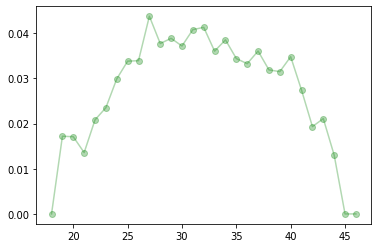

In [9]:
# モデリングを行う前に，本塁打率（Homerun Rate: HRR）を傾向を調べておきます．年齢毎に本塁打率の中央値を算出し，可視化します．
def plot_basic_HRR():
    data['HRR'] = data['HR'] / data['AB']
    
    data.groupby('age').agg({'HRR': np.median}).reset_index().pipe(
        lambda df: plt.plot(df['age'], df['HRR'], "o-", color="green", alpha=0.3)
    )


plot_basic_HRR()

本塁打率は年齢に応じてスムーズに変化しそうですが，単純にデコボコしていますね． 以後，上記データフレームdataを使って，統計的モデリングを行います．

### 統計的モデリング

In [10]:
# 統計モデリング用
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
from jax import random

# ベイジアンモデリング用の可視化ライブラリ
import arviz as az

## 統計モデリングにCPU/GPUのいずれを使うかの指定
#numpyro.set_platform("cpu")

In [11]:
# GPUだとMCMC遅いのでcpu使う
numpyro.set_platform("cpu")

#### シグモイド関数（本塁打率計算用）
ロジット関数から二項分布に設定する確率を求めるために，シグモイド関数を定義しておきます．

なお，NumPyroのBinomialクラスは，logitsパラメータにロジット関数を設定すれば，その情報をもとに二項分布の確率を自動的に設定してくれます．

今回シグモイド関数を用意したのは，モデリング後に本塁打率をトレースしたいためです．

In [12]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

#### 可視化用関数の準備
MCMCサンプルからr_ageおよびHRR_age（後述）の事後分布を年齢ごとに可視化するための関数を定義します．パラメータの推定値（中央値）を95%予測区間とともに可視化します

In [13]:
def plot_r_age_posterior(_samples):
    age_range = [i for i in range(min_age, max_age)]

    # 中央値のプロット
    r_age_median = np.median(_samples['r_age'], axis=0)    
    plt.plot(age_range, r_age_median, "o-", color="blue")
    
    # HPD(Highest Posterior Density) intervalの表示
    az.plot_hdi(age_range, _samples['r_age'], color="blue", fill_kwargs={'alpha': 0.1})

In [14]:
def plot_HRR_posterior(_samples):
    age_range = [i for i in range(min_age, max_age)]

    # 中央値のプロット
    HRR_age_median = np.median(_samples['HRR_age'], axis=0)    
    plt.plot(age_range, HRR_age_median, "o-", color="blue")
    
    # HPD(Highest Posterior Density) intervalの表示
    az.plot_hdi(age_range, _samples['HRR_age'], color="blue", fill_kwargs={'alpha': 0.1})

## モデル1：年齢を考慮した階層ベイズ
@muijpさんの記事では，野球選手は潜在的に本塁打率を有しており，各シーズンで打った本塁打数は「打席数」と「本塁打率」をパラメータとする二項分布に従うと仮定しています．既に述べたように，本記事は@muijpさんの記事内容を踏襲します．

モデル1では
- 本塁打率に選手間で共通
- 本塁打率は年齢によって異なる
- 本塁打率は年齢間で依存関係はない
と仮定しています．選手を$i$，選手$i$の年齢を$age[i]$，選手$i$の打数を$AB[i]$，本塁打数を$HR[i]$としたとき，モデル1では選手$i$の本塁打率$HRR[i]$，および年齢$j$が本塁打率に与える影響$r_{age}[j]$を以下のようにモデリングします．

$$
    \begin{align}
        \mathit{HR}[i] \sim \mathit{Binomial}(\mathit{AB}[i], \mathit{HRR}[i]) \\
        \mathit{HRR}[i] = \frac{1}{1 + e^{-(\beta + r_{age}[age[i]])}} \\        
        \beta \sim \mathit{N}(0, 1) \\
        r_{age}[j] \sim \mathit{N}(0, sd_{age}) \\
        sd_{age} \sim \mathit{HalfCauchy}(1)         
    \end{align}
$$

**パラメータ 本塁打率 $HRR[i]$ も確率分布を仮定し、確率分布の本塁打率を用いて 本塁打数 $HR[i]$ を出しているから階層ベイズになってる**

※HalfCauchy: Half-Cauchy分布. ピークの位置以上の値に対してゼロ以外の確率密度のみを持つように切り捨てられたコーシー分布
- https://distribution-explorer.github.io/continuous/halfcauchy.html

In [15]:
# model
def model_1(ABs, HRs=None, ages=None):
    player_num = ABs.shape[0]
    
    beta = numpyro.sample("beta", dist.Normal(0, 1))
    sd_age = numpyro.sample("sd_age", dist.HalfCauchy(1))
    with numpyro.plate("age_num", max(ages)):
        r_age = numpyro.sample("r_age", dist.Normal(0, sd_age))
        numpyro.deterministic('HRR_age', sigmoid(beta + r_age)) # 年齢毎の本塁打率をtraceするために保存しておく        

    # logit=xとすると，logit(p) = x 
    HRRs = beta + r_age[ages]
    numpyro.sample("obs", dist.Binomial(ABs, logits=HRRs), obs=HRs)

In [16]:
%%time
# MCMCサンプリング
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 3000
kernel = NUTS(model_1)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key, data.AB.values, data.HR.values, data.modified_age.values)

samples = mcmc.get_samples()

# 推定パラメータの基本統計量
mcmc.print_summary()

sample: 100%|██████████████████████████████████████| 4000/4000 [00:04<00:00, 874.58it/s, 31 steps of size 1.16e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta     -3.38      0.06     -3.37     -3.47     -3.29    233.17      1.00
  r_age[0]     -0.05      0.28     -0.04     -0.54      0.37   2051.75      1.00
  r_age[1]     -0.48      0.18     -0.47     -0.78     -0.20   1499.41      1.00
  r_age[2]     -0.28      0.10     -0.28     -0.43     -0.11    809.32      1.00
  r_age[3]     -0.07      0.07     -0.07     -0.19      0.05    385.81      1.00
  r_age[4]     -0.20      0.07     -0.20     -0.31     -0.09    374.51      1.00
  r_age[5]     -0.03      0.07     -0.03     -0.13      0.08    317.61      1.00
  r_age[6]      0.03      0.06      0.03     -0.07      0.14    318.92      1.00
  r_age[7]      0.09      0.06      0.09     -0.01      0.20    285.71      1.00
  r_age[8]      0.17      0.06      0.17      0.07      0.27    313.53      1.00
  r_age[9]      0.23      0.06      0.22      0.13      0.33    281.82      1.00
 r_age[10]      0.25      0

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


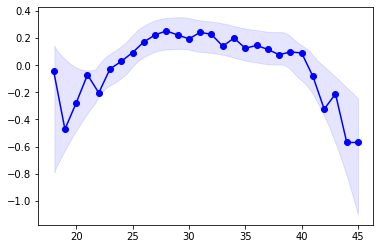

In [17]:
# 年齢の影響度（$r_{age}$）の推定
plot_r_age_posterior(samples)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


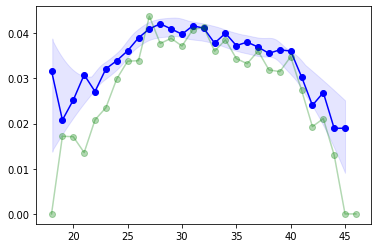

In [18]:
# 年齢ごとの本塁打率（$HRR$）の推定
# 青いラインが推定された本塁打率．緑のラインは，単純に本塁打率の中央値を年齢ごとにプロットしたもの
plot_HRR_posterior(samples)
plot_basic_HRR()

結果を見てみるとうーんという感じがしますね。

問題点(c)はたしかに部分的に解決したと思いますが、(a)の個人差の問題と(b)のノイズの問題については何もできていません。

たとえば、相変わらず39歳で急に本塁打を打てることになっていますし、さらに新たな問題としてデータ点が少ない40代以降で能力が向上するという、現実的とは考えづらい結果になっています
（これは、たぶん全年齢の平均に近づいた方が尤度が高くなるせいだと思います）。

https://qiita.com/muijp/items/7b6097edfcdb30fc6ae8

## モデル2：時系列を考慮
モデル1では「本塁打率に選手間で共通」かつ「本塁打率は年齢によって異なる」としつつ「本塁打率は年齢間で依存関係はない」と仮定しました．しかし，本塁打率は年齢間に関係があることは容易に想像できます．そこで，モデル2では「年齢$j$における本塁打率は，年齢$j-1$における本塁打率から影響を受ける」と仮定します．

本記事では，「年齢$j$における本塁打率は年齢$j-1$における本塁打率を平均値とする正規分布に従う」という仮定を採用し，この仮定をNumPyroのGaussianRandomWalk分布で表現します．モデルは以下の通りです．

$$
    \begin{align}
        \mathit{HR}[i] \sim \mathit{Binomial}(\mathit{AB}[i], \mathit{HRR}[i]) \\
        \mathit{HRR}[i] = \frac{1}{1 + e^{-(\beta + r_{age}[age[i]])}} \\        
        \beta \sim \mathit{N}(0, 1) \\
        r_{age}[j] \sim \mathit{N}(r_{age}[j-1], sd_{age}) \\
        sd_{age} \sim \mathit{HalfCauchy}(1)         
    \end{align}
$$
以下，モデル2をNumPyroで記述し，各種パラメータの事後分布を推定します．

In [19]:
# model
def model_2(ABs, HRs=None, ages=None):
    player_num = ABs.shape[0]
    
    beta = numpyro.sample("beta", dist.Normal(0., 1.))
    sd_age = numpyro.sample("sd_age", dist.HalfCauchy(.1))
    r_age = numpyro.sample("r_age", dist.GaussianRandomWalk(scale=sd_age, num_steps=int(max(ages))))
    numpyro.deterministic('HRR_age', sigmoid(beta + r_age)) # 年齢毎の本塁打率をtraceするために保存しておく        

    HRRs = beta + r_age[ages]
    numpyro.sample("obs", dist.Binomial(ABs, logits=HRRs), obs=HRs)

In [20]:
data.modified_age.values

array([ 2,  3,  4, ..., 18, 19, 20], dtype=int32)

In [21]:
# MCMCサンプリング
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 3000
kernel = NUTS(model_2)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key, data.AB.values, data.HR.values, data.modified_age.values)

samples = mcmc.get_samples()

# 推定パラメータの基本統計量
mcmc.print_summary()

sample: 100%|██████████████████████████████████████| 4000/4000 [00:07<00:00, 508.72it/s, 63 steps of size 3.56e-02. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta     -3.65      0.17     -3.65     -3.94     -3.39    158.48      1.00
  r_age[0]     -0.04      0.11     -0.03     -0.21      0.13    476.91      1.00
  r_age[1]     -0.07      0.15     -0.07     -0.31      0.16    226.17      1.00
  r_age[2]      0.01      0.17      0.01     -0.24      0.30    175.92      1.00
  r_age[3]      0.14      0.17      0.15     -0.12      0.43    168.54      1.00
  r_age[4]      0.09      0.18      0.10     -0.17      0.40    162.66      1.00
  r_age[5]      0.23      0.18      0.24     -0.06      0.51    164.42      1.00
  r_age[6]      0.30      0.17      0.31      0.01      0.58    162.42      1.00
  r_age[7]      0.36      0.17      0.37      0.08      0.64    162.17      1.00
  r_age[8]      0.44      0.17      0.45      0.17      0.72    162.57      1.00
  r_age[9]      0.49      0.17      0.50      0.22      0.79    162.93      1.00
 r_age[10]      0.52      0

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


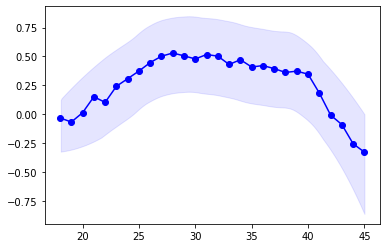

In [22]:
# 年齢の影響度（$r_{age}$）の推定
plot_r_age_posterior(samples)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


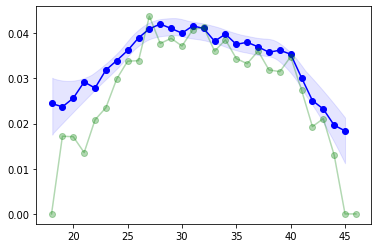

In [23]:
# 年齢ごとの本塁打率（$HRR$）の推定
# 青いラインが推定された本塁打率．緑のラインは，単純に本塁打率の中央値を年齢ごとにプロットしたもの
plot_HRR_posterior(samples)
plot_basic_HRR()

なるほど〜。モデル1と比べると良い点が２つあります。

- 39歳での能力の高まりが少し抑えられた。
- 40代での能力が年々下がるようになった

これはいずれも時系列を考慮した効果であり、かつ現実に即した結果であると考えられます。ということで、問題点(b)のノイズについて少しは改善した気がします。そこで、最後に個人差を考慮したモデルを作りましょう。

https://qiita.com/muijp/items/7b6097edfcdb30fc6ae8

## モデル3：個人差を考慮（GLMM）
モデル2では「年齢$j$における本塁打率は，年齢$j-1$における本塁打率から影響を受ける」と仮定しましたが，本塁打率は各選手によって潜在的に異なる，つまり個体差があると考えられます．高齢の選手ほどデータ数が少なくなります．また，高齢の選手は有能な選手だからこそ高齢までプレーを続けることができたと考えられるため，高齢のデータはある意味特殊な事例であり，そのデータを使って一般的な本塁打率を推定するのはやや無理があります．そのため，個体差を考慮した統計モデリングが必要となってきます．

個体差$r_{player}$を考慮してモデリングを行いましょう．モデル3は以下の通りです：

$$
    \begin{align}
        \mathit{HR}[i] \sim \mathit{Binomial}(\mathit{AB}[i], \mathit{HRR}[i]) \\
        \mathit{HRR}[i] = \frac{1}{1 + e^{-(\beta + r_{age}[age[i]] + r_{player}[i])}} \\        
        \beta \sim \mathit{N}(0, 1) \\
        r_{age}[j] \sim \mathit{N}(r_{age}[j-1], sd_{age}) \\
        sd_{age} \sim \mathit{HalfCauchy}(1) \\
        r_{player}[i] \sim \mathit{N}(0, sd_{player}) \\
        sd_{player} \sim \mathit{HalfCauchy}(1)
    \end{align}
$$
以下，モデル3をNumPyroで記述し，各種パラメータの事後分布を推定します．

In [24]:
# model
def glmm_model(ABs, HRs=None, ages=None):
    player_num = ABs.shape[0]
    
    beta = numpyro.sample("beta", dist.Normal(0, 1))
    sd_player = numpyro.sample("sd_player", dist.HalfCauchy(1))
    sd_age = numpyro.sample("sd_age", dist.HalfCauchy(.1))
    r_age = numpyro.sample("r_age", dist.GaussianRandomWalk(scale=sd_age, num_steps=int(max(ages))))
    numpyro.deterministic('HRR_age', sigmoid(beta + r_age)) # 年齢毎の本塁打率をtraceするために保存しておく        
    
    with numpyro.plate("player_num", player_num):
        r_player = numpyro.sample("r_player", dist.Normal(0, sd_player))
        HRRs = beta + r_age[ages] + r_player
        numpyro.sample("obs", dist.Binomial(ABs, logits=HRRs), obs=HRs)

In [25]:
# MCMCサンプリング
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 3000
kernel = NUTS(glmm_model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key, data.AB.values, data.HR.values, data.modified_age.values)

samples = mcmc.get_samples()

# 推定パラメータの基本統計量
mcmc.print_summary()

sample: 100%|█████████████████████████████████████| 4000/4000 [00:27<00:00, 147.38it/s, 127 steps of size 2.56e-02. acc. prob=0.94]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
          beta     -3.71      0.21     -3.72     -4.03     -3.34     96.16      1.04
      r_age[0]     -0.04      0.11     -0.03     -0.22      0.13    254.26      1.01
      r_age[1]     -0.07      0.16     -0.06     -0.32      0.19    175.72      1.01
      r_age[2]     -0.07      0.19     -0.06     -0.41      0.22    139.93      1.02
      r_age[3]     -0.07      0.21     -0.06     -0.43      0.26    130.78      1.02
      r_age[4]     -0.03      0.22     -0.02     -0.38      0.34    108.81      1.03
      r_age[5]      0.07      0.22      0.08     -0.28      0.44    103.27      1.03
      r_age[6]      0.16      0.22      0.16     -0.20      0.53     95.15      1.04
      r_age[7]      0.24      0.22      0.25     -0.12      0.59    100.53      1.04
      r_age[8]      0.33      0.22      0.33     -0.04      0.67    108.43      1.04
      r_age[9]      0.38      0.22      0.39      0.01      0.74

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


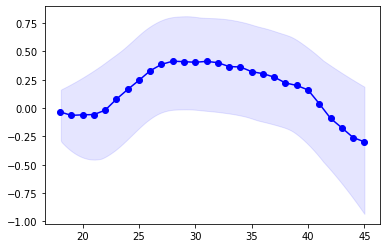

In [26]:
# 年齢の影響度（$r_{age}$）の推定
plot_r_age_posterior(samples)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


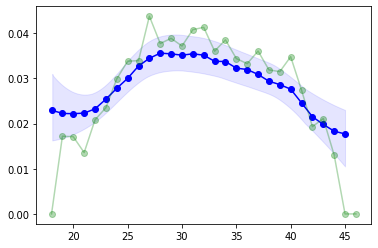

In [27]:
# 年齢ごとの本塁打率（$HRR$）の推定
# 青いラインが推定された本塁打率．緑のラインは，単純に本塁打率の中央値を年齢ごとにプロットしたもの
plot_HRR_posterior(samples)
plot_basic_HRR()

なるほど〜。これはかなりいい感じの結果ではないでしょうか。

年齢が能力ごとに滑らかに変化しており、かなり妥当に見えます。

ここで、pagepageの推定値が実測値よりもかなり小さくなっていますが、これは推定値は「年齢ごとの平均的な選手のpagepage」を表しているからだと思います。

実測値ではすごい選手ほど打席が多くなると思うので、全体の平均をとるとすごい選手の比重がすごくない選手よりも高くなり、結果として平均的な選手のpagepageよりもすごい値がでます。

結論としては、29歳の選手が一番本塁打を打つ確率が高く、平均的な選手で2.5%よりを少し上回る程度です。

29歳の前後での能力の変化を見ると、29歳以前での成長の方が29歳以後の衰えよりも急な変化になっていることがわかりますね。

また、例えばだいたい20歳前後でのpagepageが1.5%より少し高い程度なので、平均的には30歳前後の選手は20歳前後の選手よりも(2.5/1.5)≃1.7(2.5/1.5)≃1.7倍くらい本塁打を期待できることになりますね。

まだいろいろとできると思いますが、とりあえずこの辺で、、、。

https://qiita.com/muijp/items/7b6097edfcdb30fc6ae8

以上で，@muijpさん執筆の「野球選手が本塁打を一番打てるのは何歳のときなのかPythonとStanで求める」(https://qiita.com/muijp/items/7b6097edfcdb30fc6ae8) のNumPyroでの再現を終えます